In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')


#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KXIF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KXIF\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KXIF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KXIF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KXIF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KXIF\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
c:\Users\KXIF\ana

In [2]:
import os
os.listdir("E:\Workspace\Coding\Text Classification — NLP")
df_train=pd.read_csv('train.csv')
print(df_train.shape)
df_train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


c:\Users\KXIF\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: ylabel='target'>

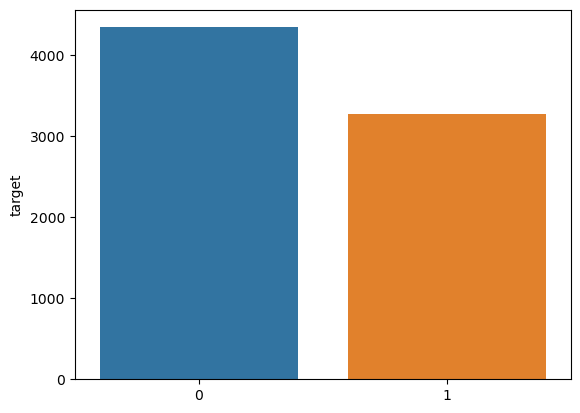

In [3]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [4]:
#Missing values
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
#1. WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print("Disaster Tweets Word Count Mean", df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print("Non-Disaster Tweets Word Count Mean", df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print("Disaster Tweets Character Count Mean", df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print("Non-Disaster Tweets Character Count Mean", df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print("Disaster Tweets Unique Word Count Mean", df_train[df_train['target']==1]['unique_word_count'].mean()) #Disaster tweets
print("Non-Disaster Tweets Unique Word Count Mean", df_train[df_train['target']==0]['unique_word_count'].mean()) #Non-Disaster tweets

Disaster Tweets Word Count Mean 15.167532864567411
Non-Disaster Tweets Word Count Mean 14.704744357438969
Disaster Tweets Character Count Mean 108.11342097217977
Non-Disaster Tweets Character Count Mean 95.70681713496084
Disaster Tweets Unique Word Count Mean 14.664934270865178
Non-Disaster Tweets Unique Word Count Mean 14.09649930907416


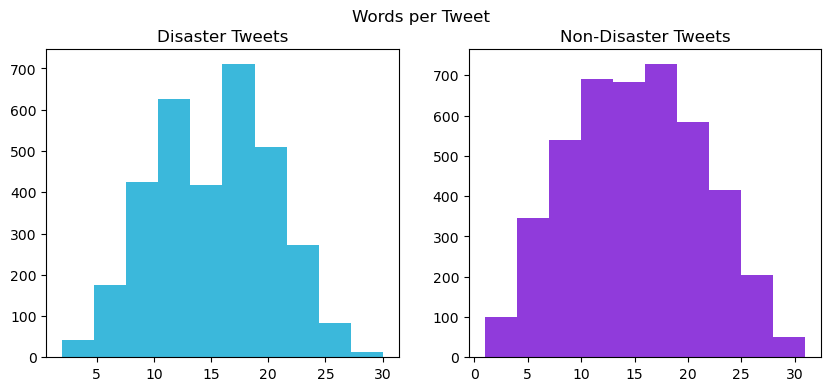

In [6]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='#3bb8db')
ax1.set_title('Disaster Tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='#903bdb')
ax2.set_title('Non-Disaster Tweets')
fig.suptitle('Words per Tweet')
plt.show()

In [7]:
#0. Common text preprocessing

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [8]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get sent photo ruby alaska smoke wildfires pou...


In [9]:
# create Word2vec model

df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents

w2v = dict(zip(model.wv.index_to_key, model.wv))  #combination of word and its vector


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [10]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["target"],
                                                  test_size=0.2,
                                                  shuffle=True)

X_train_tok= [nltk.word_tokenize(i) for i in X_train]
X_val_tok= [nltk.word_tokenize(i) for i in X_val]

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [11]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       865
           1       0.74      0.73      0.74       658

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[700 165]
 [177 481]]
AUC: 0.8406987367570321


In [12]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       865
           1       0.82      0.64      0.72       658

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Confusion Matrix: [[775  90]
 [236 422]]
AUC: 0.8441687017938401


In [13]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.65      0.82      0.73       865
           1       0.64      0.43      0.52       658

    accuracy                           0.65      1523
   macro avg       0.65      0.62      0.62      1523
weighted avg       0.65      0.65      0.64      1523

Confusion Matrix: [[705 160]
 [372 286]]
AUC: 0.6943558163641795


In [14]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('test.csv')  #reading the data
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))         #preprocessing the data

X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test)

y_predict = lr_tfidf.predict(X_vector)
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

df_test['predict_prob']= y_prob
df_test['target']= y_predict

print(df_test.head())

final=df_test[['id','target']].reset_index(drop=True)
final.to_csv('test_results.csv')

   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   

                                          clean_text  predict_prob  target  
0                          happen terrible car crash      0.793228       1  
1  heard earthquake different city stay safe ever...      0.684517       1  
2  forest fire spot pond geese flee across street...      0.669547       1  
3                  apocalypse light spokane wildfire      0.821343       1  
4                 typhoon soudelor kill china taiwan      0.993905       1  
